# To-do list

## Metalicty

# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>



# rotaation bv and age observers GC
# period age mass and metalictty fundemental GC


In [1]:
!pip install arviz==0.11.0
!pip install pymc3==3.11.1
!pip install PyAstronomy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import pandas as pd

import pymc3 as pm
import theano as tt
import arviz 
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on PyMC3 v3.11.1


Using:  (45,)
From:  (1450, 4)


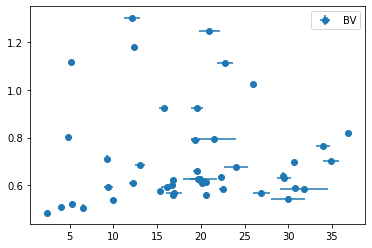

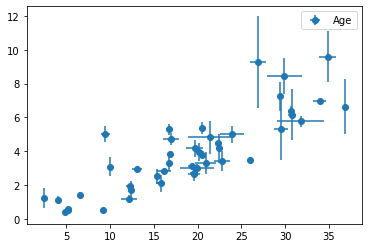

In [3]:
##### OPTIONS #####
#data1 16th points = 91 total


smp_rt = 30    # every nth point of true data



data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
b = pyasl.BallesterosBV_T()
BV =  b.t2bv(np.array(Teff))

#data 1 and data 2 have differnet columns! 


##  constricting to a sensible range and ordering by rotation 
sel = np.where((Age>0.4)& (Prot>2))
Age = Age[sel]
Prot = Prot[sel]
BV = BV[sel]

order = np.argsort(Prot)
Age = Age[order]
Prot=Prot[order]
BV=BV[order]


data_points = Prot.shape[0]
data_noise = True



## Here is where I am adding some noise to the data roughly 5% for mass prot and Teff, 20% for Age
n_age = 0.2
n_oth = 0.04
n_bv =  0.01

if data_noise:


  Age_err = np.random.normal(0,1, len(Age))*Age*n_age
  BV_err = np.random.normal(0,1, len(Age))*BV*n_bv

  Prot_err = np.random.normal(0,1, len(Age))*Prot*n_oth


  Age  += Age_err
  BV += BV_err
  Prot += Prot_err 

print('Using: ',data_points)
print('From: ',data.shape)

plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='BV')
plt.legend()
plt.show()
plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='Age')
plt.legend()
plt.show()


In [4]:
def mean_fn(Age, BV, A, c, h, f):
  return A * Age**c  * (BV-h)**f


https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [5]:
#### book ####

g = 0.77
h = 0.4 
f = 0.6 
c = 0.52 
A = 0.77


X = np.array([Age, BV]).T 

with pm.Model() as model:
    c_ = pm.Normal('c_', c, c*0.0007)
    f_ = pm.Normal('f_', f, f*0.05)
    A_ = pm.Normal('A_', A*g, A*0.1)
   # c_ = c
    #f_ = f
    #A_ = A
  
    Age_true = pm.Uniform('Age_true', 0, 14, shape=data_points)
    Age_obs = pm.Normal("Age_obs", Age_true, X[:,0]*n_age, observed=X[:,0])

    BV_true = pm.Lognormal("BV_true", 1, 1, shape=data_points)
    BV_obs = pm.Normal("BV_obs", BV_true, X[:,1]*n_bv, observed=X[:,1])

    mean = A_* Age_true**c_ * (BV_true - h)**f_
    resid = Prot - mean
   
    l1 = pm.Normal('l1', mu=20, sigma=1)  # 1
    l2 = pm.Normal('l2', mu=0.05, sigma=0.01)

    sf1 = pm.Lognormal("sf1", np.log(1), 0.1)
    sf2 = pm.Lognormal("sf2", np.log(1), 0.1)

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2

    K = K1 + K2 


    gp = pm.gp.Marginal(cov_func=K)
    x = tt.tensor.stack([Age_true, BV_true])

    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=n_oth*Prot)

    # big gp book says constnat plus a product of linear + white noise will do the trick
   

(45, 2)
(45,)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sf2, sf1, l2, l1, BV_true, Age_true, A_, f_, c_]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 316 seconds.


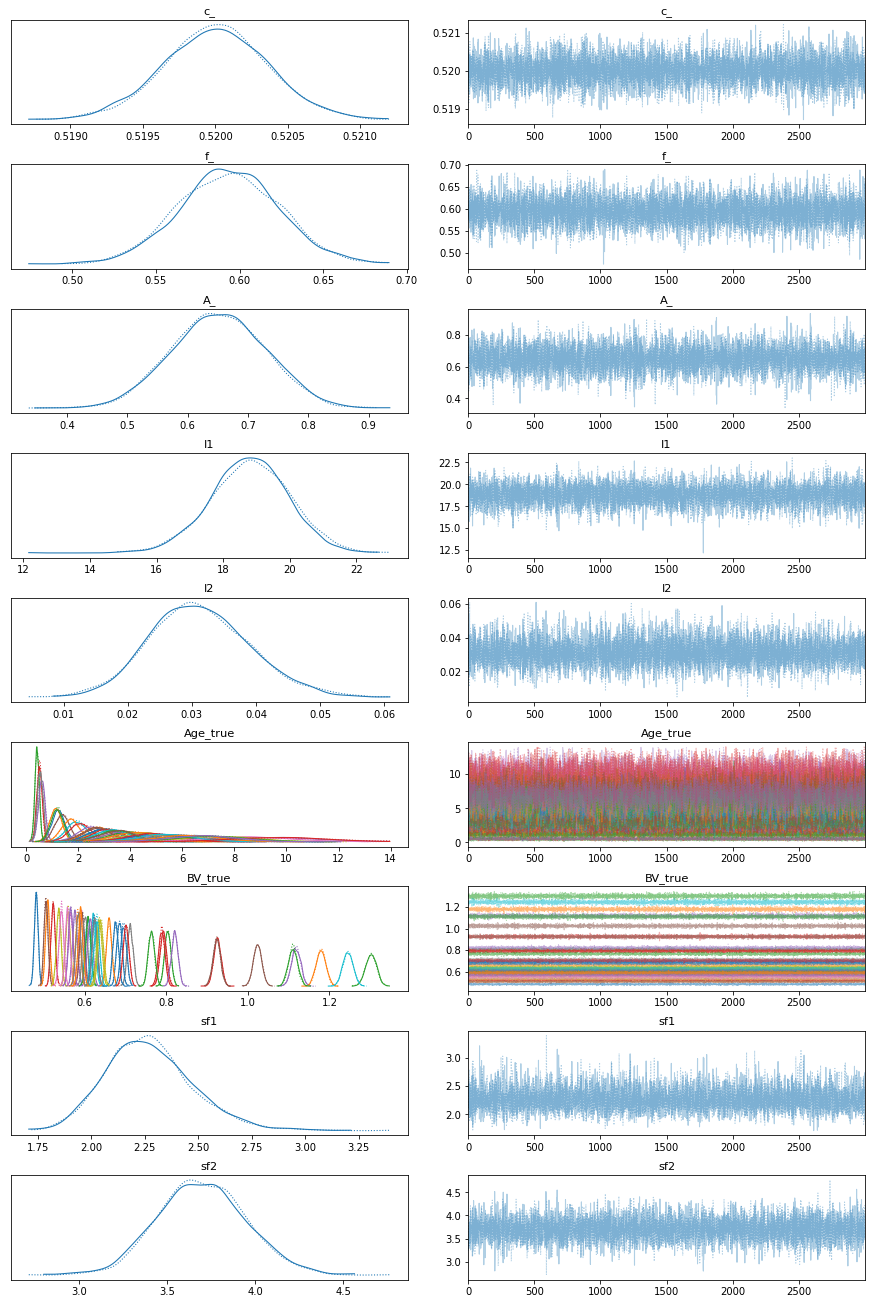

In [6]:

with model:
  trace = pm.sample(3000, tune=3000, cores=2)#, target_accept=0.95)
  arviz.plot_trace(trace)

In [7]:
with model:
  print(arviz.summary(trace))


lst = trace.varnames
# list of all variables to sample posterior over
lst.append('f_pred')
vars = np.asarray(lst)

with model:
  f_pred = gp.conditional('f_pred', X, pred_noise=False) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, var_names=vars,samples=2500)


                mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
c_             0.520  0.000   0.519  ...   10372.0    4202.0    1.0
f_             0.594  0.030   0.536  ...   14179.0    4181.0    1.0
A_             0.651  0.079   0.499  ...    9805.0    4383.0    1.0
l1            18.804  1.178  16.552  ...    7749.0    4592.0    1.0
l2             0.031  0.008   0.016  ...   11261.0    4267.0    1.0
Age_true[0]    1.236  0.245   0.777  ...    9683.0    3683.0    1.0
Age_true[1]    1.137  0.230   0.722  ...   10062.0    3911.0    1.0
Age_true[2]    0.420  0.084   0.262  ...   10316.0    3588.0    1.0
Age_true[3]    0.511  0.101   0.324  ...    9098.0    3488.0    1.0
Age_true[4]    0.602  0.125   0.372  ...    9740.0    3720.0    1.0
Age_true[5]    1.380  0.288   0.869  ...   10389.0    3509.0    1.0
Age_true[6]    4.980  1.010   3.161  ...   11512.0    3922.0    1.0
Age_true[7]    0.543  0.110   0.331  ...   10553.0    3795.0    1.0
Age_true[8]    3.075  0.602   1.956  ...   10312

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [8]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points[0])])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("I have added {}% error :)".format(round(new_err-old_err,5)*100))


Initianl error:  14.131458756599786 %
New error:  19.958873568482876 %
I have added 5.827% error :)


No handles with labels found to put in legend.


[ 2.42384674  4.05937745  4.89026205  5.28357802  5.35598294  6.58550887
  9.71038326  9.41696099 10.13873863 12.37811537 13.30344945 12.60361954
 12.3551142  15.78732834 15.43952676 16.24148151 17.05067669 16.81359371
 16.89084729 16.97330477 19.86188573 19.58501518 20.12997732 19.34042537
 20.52757461 19.53088247 20.48169515 19.75293099 22.11074623 20.915204
 23.76250039 22.3060815  22.72556902 21.61622058 26.38813958 25.53330012
 29.14677994 30.49378796 28.59489435 28.62680697 29.73558894 29.83915649
 32.3346919  33.22137005 34.73801189]


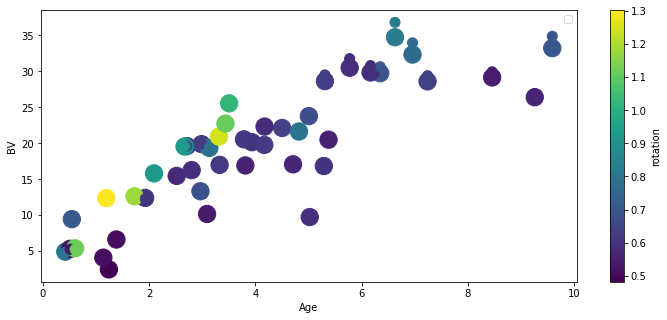

In [10]:


fig = plt.figure(figsize=(12, 5))
ax = fig.gca()



fit, var = gp.predict(X, point=trace[-1], diag=True)
sd = np.sqrt(var)


mean = mean_fn(X[:,0], X[:,1], A, c ,h,f)


mu = fit + mean


k = np.argsort(X[:,0])
#plt.fill_between(X[:,0][k], mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)


## plotting the predictions, make a plot of age on x axis b-v on y, plot points and colour by age

plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis)
plt.xlabel('Age')
plt.ylabel('BV')
plt.colorbar(label='rotation')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis)#,edgecolors='b')
plt.show()

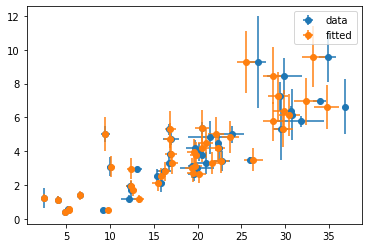

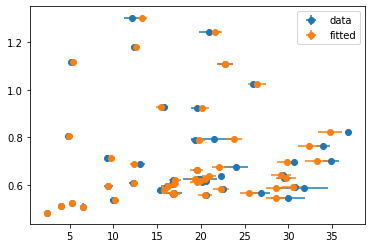

In [11]:
#A = np.mean(trace['A_'])
#c = np.mean(trace['c_'])
#h = h
#f = np.mean(trace['f_'])




fit, var = gp.predict(X, point=trace[-1], diag=True)



mu = fit + mean
std = np.sqrt(var) * np.sign(var)


vals = np.sort(np.array([mu, std, np.sort(data[:, 1][0::smp_rt][sel])]), axis=1)





age_fit_err = [trace.get_values('Age_true')[:,i].std() for i in range(trace.get_values('Age_true').shape[1])]
bv_fit_err = [trace.get_values('BV_true')[:,i].std() for i in range(trace.get_values('BV_true').shape[1])]



plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(vals[0,:], X[:,0], xerr=vals[1,:], yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')



order = np.argsort(X[:,1])


plt.errorbar(vals[0,:][order], X[:,1][order],xerr=vals[1,:][order], yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

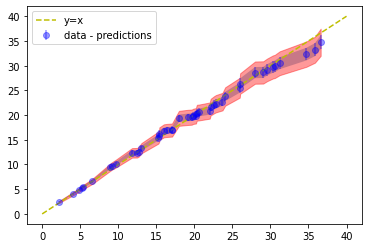

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

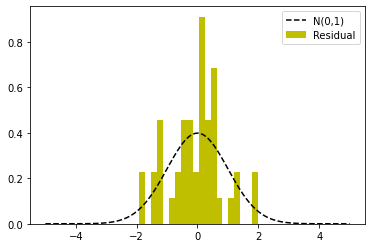

[-1.90896281 -0.32521966 -0.06988126 -0.47891287 -0.23463959  0.02964847
 -1.36279022 -1.44595242 -1.24160916 -1.13617105  0.21160352  0.2092525
 -0.50052885 -0.28707184 -0.6635778  -1.319148   -1.24206161 -0.77670224
  0.16186429  0.06811473 -1.79996568 -0.51329855  0.09011027  0.13636587
  0.4595465   0.15155586 -0.18055963  0.11202069  1.34774125  0.62820847
  0.5770216   0.61335271  1.09246485  0.31003929  0.42939803 -0.35452425
 -0.55141319  0.36905842  0.35994363  0.49759867  0.61952192  0.59940791
  1.86261106  1.99267527  1.3550652 ]
-0.04686221519537156
0.8777062913657293


In [12]:


plt.plot([0, 40], [0, 40], linestyle='--', label='y=x', color='y')
plt.errorbar(vals[2,:], vals[0,:], yerr=vals[1,:], fmt='o', label=r'data - predictions', color='b', alpha=0.4)
plt.fill_between(vals[2,:], vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], alpha=0.4)
plt.fill_between(vals[2,:], vals[0,:] - 2*vals[1,:], vals[0,:] + 2*vals[1,:],color='red', alpha=0.4)
plt.savefig("R4.png")
files.download("R4.png") 
plt.legend()
plt.show()


Z = (vals[2,:] - vals[0, :])/(vals[1,:])



x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

x = np.linspace(-5,5, 1000)
f_half = np.sqrt(2/np.pi)*np.exp(1/2*-x**2)


plt.hist(Z, density=True, label='Residual', color='y', bins=20)


plt.plot(x,f, label='N(0,1)', color='k', linestyle='--')
txt="Figure 2: The residuals of the difference betwen the predictions and the true data, normalised by the standard devition. If this was perfect, it would be a fit a N(0,1) distribution"


plt.legend()

plt.savefig("H4.png")
files.download("H4.png") 

plt.show()



print(Z)
print(np.mean(Z))
print(np.std(Z))

In [ ]:

n_comb = np.sqrt(n_age**2 + n_bv**2 +n_oth**2)
print(n_comb)

These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V